In [765]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets

# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy import stats

## 8. In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.

**(a) Use the rnorm() function to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.**

In [414]:
np.random.seed(1)
x = np.random.normal(0,1,size=100)
e = np.random.normal(0,1,size=100)

**(b) Generate a response vector Y of length n = 100 according to the model $Y=β_0+β_1X+β_2X^2+β_3X^3+ε$ , where β0, β1, β2, and β3 are constants of your choice.**

In [415]:
y_np = 2 + 2*x + 3*(x**2) + 2.5*(x**3) + e

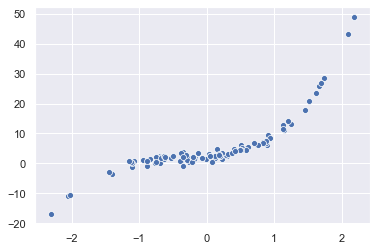

In [416]:
sns.scatterplot(x,y_np)

**(c) Use the regsubsets() function to perform best subset selection in order to choose the best model containing the predictors X,X2,...,X10. What is the best model obtained according to Cp, BIC, and adjusted R2? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the data.frame() function to create a single data set containing both X and Y .**

In [417]:
def get_model(k,X,y):
    
    #list available predictors
    X_pred  = itertools.combinations(list(X.columns),k)
    
    # fit all models
    models = []
    for predictors_comb in X_pred:
        X_smf = ' + '.join(predictors_comb)
        f = '{} ~ {}'.format(y.columns[0],X_smf)
        model = smf.ols(formula=f,data=pd.concat([X,y],axis=1)).fit()
        models += [(f,model)]
    return models

def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]

In [418]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

subset = []
for i in range(1,len(X.columns)+1):
    subset += [get_model(i,X,y)]
    print('Progress {}: done'.format(i))

Progress 1: done
Progress 2: done
Progress 3: done
Progress 4: done
Progress 5: done
Progress 6: done
Progress 7: done
Progress 8: done
Progress 9: done
Progress 10: done


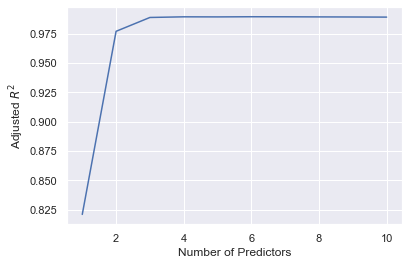

Best selection model coef.:

Intercept    2.298519
X            2.659149
X2           2.617578
X5           2.279830
X7          -0.684882
X9           0.065720
X10          0.001195
dtype: float64


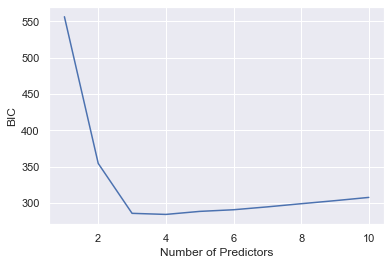

Best selection model coef.:

Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


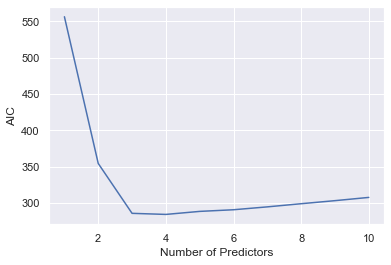

Best selection model coef.:

Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


In [419]:
k = np.arange(1,len(X.columns)+1)

display(HTML('<h3> Adjusted R^2 </h3>' ))

adjusted_r2 = [ max_adjr2(m)[1].rsquared_adj for m in subset ] 
# [1] because the first index is the "model description while the second is the model itself"

sns.lineplot(x=k,y=adjusted_r2)
plt.xlabel("Number of Predictors")
plt.ylabel("Adjusted $R^2$")
plt.show()

# select best model
coef_r2 =   [ [max_adjr2(m)[1].rsquared_adj,max_adjr2(m)[1].params ] for m in subset ]
print("Best selection model coef.:\n\n{}".format(max(coef_r2)[1]))

display(HTML('<h3> Bayes Information Criteria </h3>' ))

bayes_inf = [min_bic(m)[1].bic for m in subset]
sns.lineplot(x=k,y=bayes_inf)
plt.xlabel("Number of Predictors")
plt.ylabel("BIC")
plt.show()

coef_bic =   [ [min_bic(m)[1].bic,min_bic(m)[1].params] for m in subset ]
print("Best selection model coef.:\n\n{}".format(min(coef_bic)[1]))

display(HTML('<h3> Akaike\'s Information Criteria </h3>' ))

AIC = [min_aic(m)[1].bic for m in subset]
sns.lineplot(x=k,y=AIC)
plt.xlabel("Number of Predictors")
plt.ylabel("AIC")
plt.show()

coef_aic =   [ [min_aic(m)[1].aic,min_aic(m)[1].params] for m in subset ]
print("Best selection model coef.:\n\n{}".format(min(coef_aic)[1]))


RSS chooses a model with too many features as expected due to overfitting. BIC and AIC try to compensate for overfitting, and do a reasonable job choosing a model with one superfluous feature.

**(d) Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in (c)?**

In [420]:
def fforward_stepwise(X,Y,scorer='ssr',results=[(0, [])]):
    p_all = list(X.columns)
    p_used = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    print(p_unused)
    return
    
    #end recursion
    if not p_unused:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds}).drop(0)
    
    #Get score 
    models_fits = []
    for p in p_unused:
        f = '{} ~ {}'.format(Y.columns[0],'+'.join([p]+p_used))
        #fit model
        model_fit = smf.ols(formula= f,data= pd.concat([X,Y],axis=1)).fit()
        models_fits += [(model_fit,[p]+p_used)]
    
    if scorer == 'ssr':
        print("ssr")
        best_model = sorted(models_fits, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':       
        best_model = sorted(models_fits, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])
    elif scorer == 'bic':       
        best_model = sorted(models_fits, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(models_fits, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return forward_stepwise(X, y, scorer, new_results)

def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    ax = sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))
    

In [421]:
def backward_stepwise(X,Y,scorer='ssr',results=[]):
    p_all = list(X.columns)
    if not results:
        # fit all
        f = '{} ~ {}'.format(Y.columns[0],'+'.join(p_all))
        model = smf.ols(formula=f,data=pd.concat([X,Y],axis=1)).fit()
        #begin backwards
        if scorer== 'ssr':
            return backward_stepwise(X,Y,scorer,results=[(model.ssr,p_all)])
        elif scorer== 'bic':
            return backward_stepwise(X,Y,scorer,results=[(model.bic,p_all)])
        elif scorer =='aic':
            return backward_stepwise(X,Y,scorer,results=[(model.aic,p_all)])
        elif scorer == 'rsquared_adj':
            return backward_stepwise(X,Y,scorer,results=[(model.rsquared_adj,p_all)])
    else:
        p_used = results[-1][1]
    
    if len(p_used)==1:
        scores = [r[0] for r in results]
        models = [r[1] for r in results]
        return pd.DataFrame({scorer:scores,'predictors':models})

    r=[]
    #get RSS for each possible predictor to be removed:
    for p in p_used:
        p_test = [i for i in p_used if i!=p]
        f = '{} ~ {}'.format(Y.columns[0],'+'.join(p_test))
        model_2 = smf.ols(formula=f,data=pd.concat([X,Y],axis=1)).fit()
        r += [(model_2,p_test)]
    
    if scorer== 'ssr':
        best_model = sorted(r,key=lambda tup:tup[0].ssr)[0]
        best_score = (best_model[0].ssr,best_model[1])
    elif scorer == 'rsquared_adj':       
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])
    elif scorer== 'bic':
        best_model = sorted(r,key=lambda tup:tup[0].bic)[0]
        best_score = (best_model[0].bic,best_model[1])
    elif scorer == 'aic':
        best_model = sorted(r,key=lambda tup:tup[0].aic)[0]
        best_score = (best_model[0].aic,best_model[1])
        
    new_results = results + [best_score]
    
    return backward_stepwise(X,Y,scorer,new_results)
    
    
    

In [422]:
backward_stepwise(X,y,scorer='rsquared_adj')

,rsquared_adj,predictors
0,0.989162,"[X, X2, X3, X4, X5, X6, X7, X8, X9, X10]"
1,0.989267,"[X, X2, X4, X5, X6, X7, X8, X9, X10]"
2,0.989343,"[X, X2, X4, X5, X6, X7, X8, X9]"
3,0.989431,"[X, X2, X4, X5, X6, X7, X9]"
4,0.989395,"[X, X2, X5, X6, X7, X9]"
5,0.988398,"[X, X2, X5, X7, X9]"
6,0.987560,"[X, X2, X5, X7]"
7,0.979798,"[X, X2, X5]"
8,0.887135,"[X2, X5]"
9,0.675278,[X5]


## Forward Stepwise

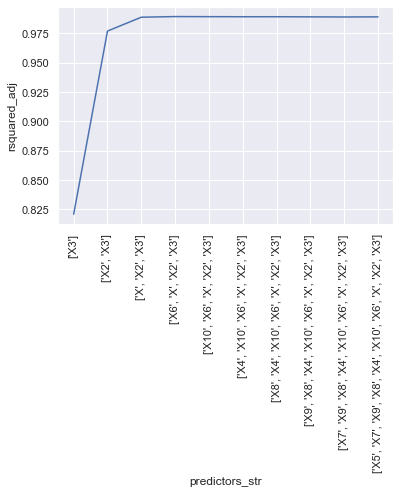

,rsquared_adj,predictors
4,0.989408,"[X6, X, X2, X3]"


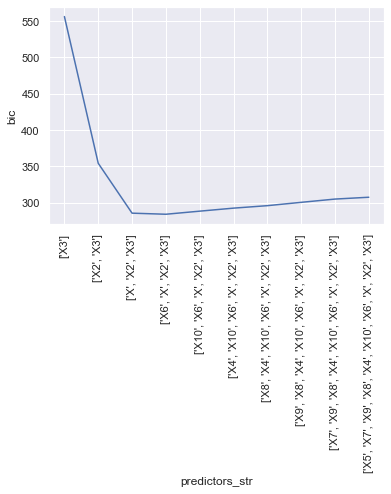

,bic,predictors
4,284.249198,"[X6, X, X2, X3]"


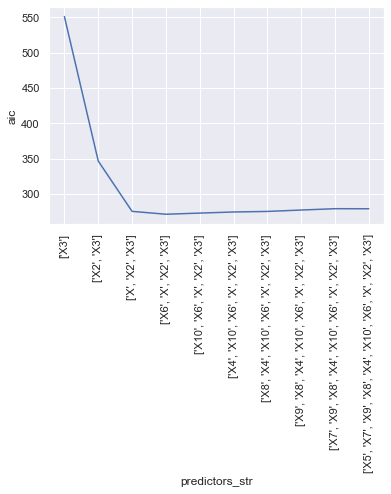

,aic,predictors
4,271.223347,"[X6, X, X2, X3]"


In [423]:
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

## Backward Stepwise

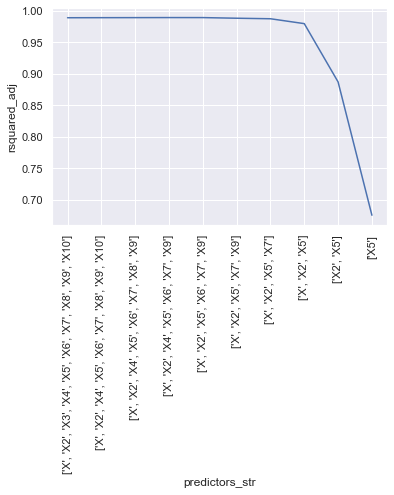

,rsquared_adj,predictors
3,0.989431,"[X, X2, X4, X5, X6, X7, X9]"


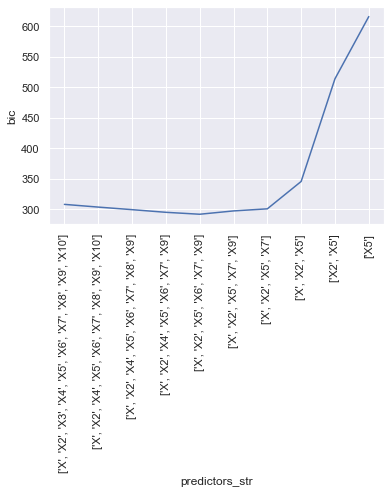

,bic,predictors
4,291.450514,"[X, X2, X5, X6, X7, X9]"


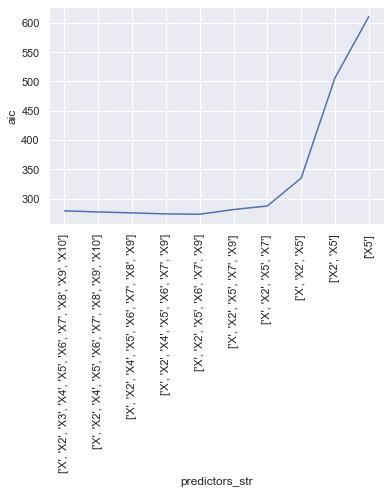

,aic,predictors
4,273.214322,"[X, X2, X5, X6, X7, X9]"


In [424]:
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

Comment:

Forward stepwise selection chooses the same models as best susbset selection for all metrics.

Backward stepwise selection tends to select overly complex models in this setting with 3-4 superfluous features depending on the metric used.

Revision note: It seems somewhat down to chance as to which approach – forward or backward – will work best in a giving setting. In reality without simulation we won't have the luxury of knowing the true optimum, so how do we choose?

**(e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.**

In [448]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size
    
def lasso_cv(X,y,λ, k):
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=False, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

        
        

,λ,MSE
19,0.19,1.814544


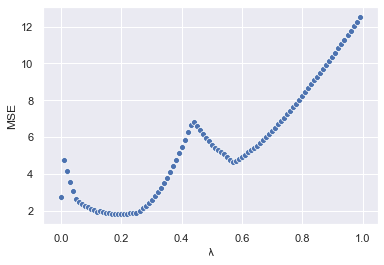

In [457]:
lambeda = np.arange(0,1,0.01)
results= []
for lam in lambeda:
    results += [np.mean(lasso_cv(X,y,lam,10))]

data=pd.DataFrame({'λ': lambeda, 'MSE': results})
sns.scatterplot(x='λ', y='MSE',data=data );
display(data[data['MSE']==data['MSE'].min()])


    

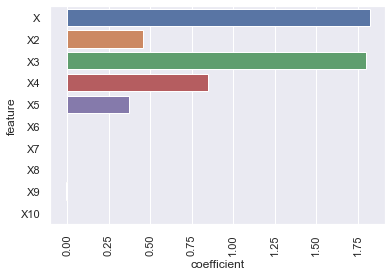

,feature,coefficient
0,X,1.823572
1,X2,0.454881
2,X3,1.802128
3,X4,0.847043
4,X5,0.373082
5,X6,0.000000
6,X7,0.000000
7,X8,-0.000000
8,X9,-0.009186
9,X10,-0.002988


In [458]:
lamb = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

Here the Lasso selects the correct features plus 4 superfluous paramaeters – 2 of which have ver low coeeficients.

**Let's apply the normalization feature of sklearn**

In [461]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size
    
def lasso_cv(X,y,λ, k):
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

        
        

,λ,MSE
1,0.002,0.889607


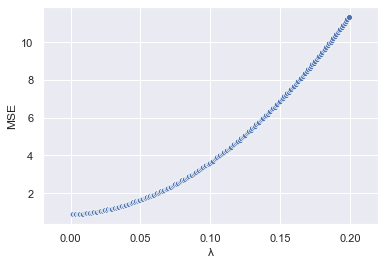

In [465]:
lambeda = np.arange(0.001,0.2,0.001)
results= []
for lam in lambeda:
    results += [np.mean(lasso_cv(X,y,lam,10))]

data=pd.DataFrame({'λ': lambeda, 'MSE': results})
sns.scatterplot(x='λ', y='MSE',data=data );
display(data[data['MSE']==data['MSE'].min()])

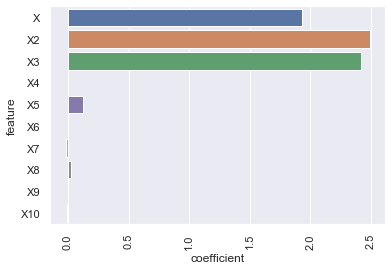

,feature,coefficient
0,X,1.928001
1,X2,2.491111
2,X3,2.421027
3,X4,0.000000
4,X5,0.125385
5,X6,0.000000
6,X7,-0.019313
7,X8,0.024454
8,X9,-0.000000
9,X10,-0.003905


In [466]:
lamb = min(zip(MSEs, lambeda))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

**(f) Now generate a response vector Y according to the model $Y=β_0+β_7X^7+ε$ , and perform best subset selection and the lasso. Discuss the results obtained**

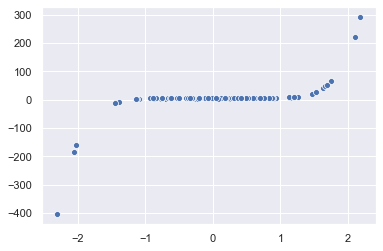

In [638]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = np.random.normal(0 ,1 , 100)

y_np = 5 + 1.2*(x**7) + eps

sns.scatterplot(x=x, y=y_np);

X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

In [622]:
def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]


def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models

def best_selection(X,y,scorer='rss'):
    
    model_subset = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k,X,y)
        model_subset += [subset]
        print("Best subset selected: {}/{}".format(k,len(X.columns)))
        
        # Select best in each subset using chosen scorer
    if scorer == 'ssr':
        # Get best rss score for each subset
        return [min_rss(m) for m in model_subset]
    elif scorer == 'rsquared_adj':
        # Get best rss score for each subset
        return [max_adjr2(m) for m in model_subset]       
    elif scorer == 'bic':
        # Get best rss score for each subset
        return [min_bic(m) for m in model_subset]
    elif scorer == 'aic':
        # Get best rss score for each subset
        return [min_aic(m) for m in model_subset]
    
        
def cross_validation(formula,X,y,k):
    
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    results = []
    for i in np.arange(len(X_folds)):
        X_test = X_folds[i]
        y_test = y_folds[i]
        X_train = X.drop(X_test.index)
        y_train = y.drop(y_test.index)
        
        #model fit
        model = smf.ols(formula=formula, data = pd.concat([X_train,y_train],axis=1)).fit()
        
        y_hat = model.predict(X_test)
        results += [mse(y_hat, y_test['y'])]
    return (results,formula)



In [623]:
best_subset_models = best_selection(X, y, scorer='bic')

Best subset selected: 1/10
Best subset selected: 2/10
Best subset selected: 3/10
Best subset selected: 4/10
Best subset selected: 5/10
Best subset selected: 6/10
Best subset selected: 7/10
Best subset selected: 8/10
Best subset selected: 9/10
Best subset selected: 10/10


In [624]:
best_subset_formula = [f[0] for f in best_subset_models ]
best_subset_mse = [np.mean(cross_validation(f,X,y,10)[0]) for f in best_subset_formula]
results = pd.DataFrame({'mse':best_subset_mse,'predictors':best_subset_formula})


In [625]:
results[results['mse'].min() == results['mse']]

,mse,predictors
2,0.854173,y ~ X2 + X6 + X7


,formula,mse
2,y ~ X2 + X6 + X7,0.854173


Intercept    5.271801
X2          -0.320021
X6           0.020727
X7           1.203961
dtype: float64

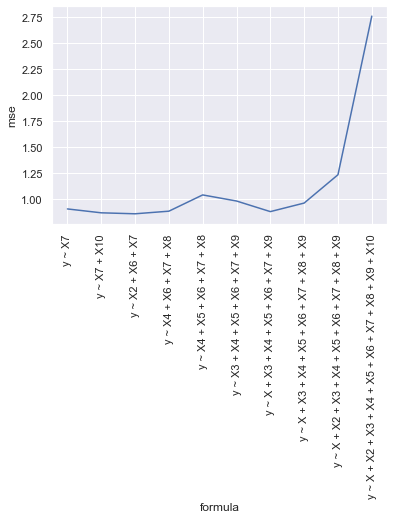

In [626]:
best_subset_formula = [f[0] for f in best_subset_models]
best_subset_mses    = [np.mean(cross_val(f, X, y, 10)[0]) for f in best_subset_formula]
df = pd.DataFrame({'formula': best_subset_formula, 'mse': best_subset_mses})

# Show chosen model
display(df[df['mse'] == df['mse'].min()])
best_subset_params = best_subset_models[2][1].params
display(best_subset_params)

# Plot mse across subsets
ax = sns.lineplot(x='formula', y='mse', data=df, sort=False)
plt.xticks(rotation=90)
plt.show();

Best subset selection with 10 fold cross validation selects a the model, $y \~ X^2 + X^6 + X^7$ with a MSE of 0.854.

Because this is simulated data we know that the true model is:

$f(x)=5+1.2x^7+ε$

Best subset selection estimates the f(x) to be:

$f(x)=5.27−0.32x^2+0.02x^6+1.20x^7$

...which is pretty close. Let's plot on the same axis to see how close

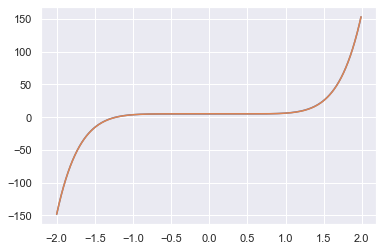

In [627]:
x = np.arange(-2,2,0.01)

y_real = 5 + 1.2* x**7 

y_apro = 5.27 - 0.32 * x**2 + 0.02*x**6+1.20 *x**7


plt.plot(x,y_real)
plt.plot(x,y_apro)


Here we plot the actual values of y (blue) and the predicted values of y (orange) on the same axis. You can't see the actual line because th eprediction is so close.

**The Lasso**

In [650]:
def lasso_cv(X,y,k,alpha):
    X_folds = np.array_split(X,k)
    y_folds = np.array_split(y,k)
    
    mses=[]
    for p in np.arange(k):
        X_test = X_folds[p]
        y_test = y_folds[p]
        X_train = X.drop(X_test.index)
        y_train = y.drop(y_test.index)
        
        #model fit
        lasso = linear_model.Lasso(alpha=alpha,fit_intercept=True,normalize=True,max_iter=10000).fit(X_train,y_train)
        
        #predict
        y_hat = lasso.predict(X_test)
        
        mses+= [mse(y_hat,y_test['y'])]
        
    return np.mean(mses)
        
        

In [651]:
lambedass= np.arange(0.01,0.1,0.001)

MSE=[]
for l in lambedass:
    MSE+= [lasso_cv(X,y,10,l)]


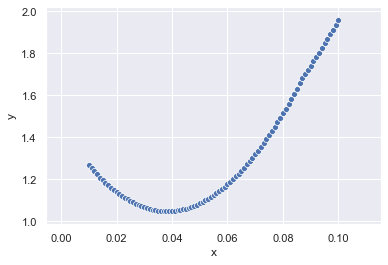

In [652]:
sns.scatterplot(x='x',y='y',data=pd.DataFrame({'x':lambedass,'y':MSE}))

In [654]:
min(zip(MSE, lambedass))

(1.0480683621470073, 0.03799999999999998)

,parameters,coef
0,X0,5.139608
0,X,0.000000
1,X2,-0.000000
2,X3,0.000000
3,X4,0.000000
4,X5,0.038361
5,X6,0.000000
6,X7,1.186932
7,X8,0.000000
8,X9,0.000000


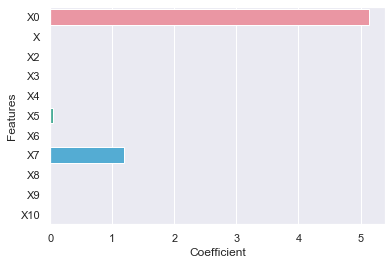

In [657]:
# which features are more important to Lasso
model = linear_model.Lasso(alpha=0.0379999,fit_intercept=True,normalize=True,max_iter=10000).fit(X,y)
intersect = pd.DataFrame({'parameters':'X0','coef':model.intercept_})
lassoa = intersect.append(pd.DataFrame({'parameters':X.columns,'coef':model.coef_}))

sns.barplot(x='coef',y='parameters',data=lassoa)
plt.xlabel("Coefficient")
plt.ylabel("Features")

display(lassoa)

Here the lasso selects almost the ideal model, with only one superfluous feature with a low coefficient. The MSE reported is marginally lower than for best subset selection at 1.048 compared to 0.854.

Whilst searching for optimal value of lambda, I noticed another minima close to zero... deomonstrated below.

,parameters,coef
0,X0,5.275241
0,X,0.546472
1,X2,-0.261390
2,X3,-2.428896
3,X4,-0.088259
4,X5,2.363543
5,X6,0.000000
6,X7,0.469777
7,X8,0.006829
8,X9,0.071042


0.00026100000000000006


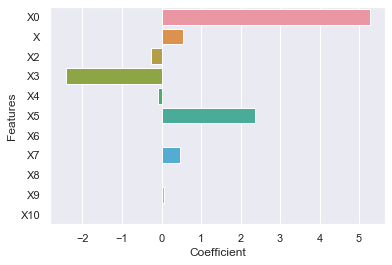

In [661]:
lambedas = np.arange(0.000001, 0.0005, 0.00001)

MSE=[]
for l in lambedas:
    MSE+= [lasso_cv(X,y,10,alpha= l)]
    
alpha =min(zip(MSE, lambedas))[1]  
model = linear_model.Lasso(alpha=alpha,fit_intercept=True,normalize=True,max_iter=10000).fit(X,y)
intersect = pd.DataFrame({'parameters':'X0','coef':model.intercept_})
lassob = intersect.append(pd.DataFrame({'parameters':X.columns,'coef':model.coef_}))

sns.barplot(x='coef',y='parameters',data=lassob)
plt.xlabel("Coefficient")
plt.ylabel("Features")

display(lassob)
print(alpha)

In [634]:
min(zip(MSEs, lambdas))

(0.8423025784930953, 0.00026100000000000006)

Here the value of lambda is very close to zero and so we expect it behave like ridge regression – indeed there is a low proportion of zero value coefficients.

The MSE is now lower 0.842 than that achieved for both best subset selection and the first version of lasso.

But how do these various model estimates compare against the actual f(x)?

Because data is simulated, we can compare the selected models to the actual model

In [700]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
X_np = np.insert(np.array(X), 0, 1, axis=1)

y_actual = 5 + 1.2*(x**7)
bss_params = np.zeros(11)
bss_params[0] = best_subset_params[0]
bss_params[2] = best_subset_params[1]
bss_params[6] = best_subset_params[2]
bss_params[7] = best_subset_params[3]

lasso_a_params = np.array(lassoa['coef'])
lasso_b_params = np.array(lassob['coef'])

In [701]:
y_bss     = X_np @ bss_params
y_lasso_a = X_np @ lasso_a_params
y_lasso_b = X_np @ lasso_b_params

def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

In [702]:
display(HTML('<h4>Actual MSEs compared to known f(x)</h4>'))
print('Best subset selection    : {}'.format(mse(y_bss, y_actual)))
print('Lasso a (higher lambda)  : {}'.format(mse(y_lasso_a, y_actual)))
print('Lasso b (lower lambda ~0): {}'.format(mse(y_lasso_b, y_actual)))

Best subset selection    : 0.0908637508688931
Lasso a (higher lambda)  : 0.09055989152231375
Lasso b (lower lambda ~0): 0.12790366350451696


In [693]:
lassob

,parameters,coef
0,X0,5.275241
0,X,0.546472
1,X2,-0.261390
2,X3,-2.428896
3,X4,-0.088259
4,X5,2.363543
5,X6,0.000000
6,X7,0.469777
7,X8,0.006829
8,X9,0.071042


### 9. In this exercise, we will predict the number of applications received using the other variables in the College data set.

**(a) Split the data set into a training set and a test set.**

In [786]:
col = pd.read_csv('College.csv',index_col=0)
col.rename_axis(['College'], inplace=True)


col = pd.get_dummies(col,drop_first=True)
col = col.astype(np.float)
col.head()

col = col.rename(index=str,columns={"F.Undergrad": "F_Undergrad", 
                                                   "P.Undergrad": "P_Undergrad",
                                                   "S.F.Ratio": "S_F_Ratio",
                                                   "perc.alumni": "perc_alumni",
                                                   "Grad.Rate": "Grad_Rate",
                                                   "Room.Board": "Room_Board"})

np.random.seed(1)
train = np.random.rand(len(col)) <  0.5
X_train = col[train].drop('Apps', axis=1)
y_train = col['Apps'][train]
X_test = col[~train].drop('Apps', axis=1)
y_test = col['Apps'][~train]

col.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
College,,,,,,,,,,,,,,,,,,
Abilene Christian University,1660.0,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0,1.0
Adelphi University,2186.0,1924.0,512.0,16.0,29.0,2683.0,1227.0,12280.0,6450.0,750.0,1500.0,29.0,30.0,12.2,16.0,10527.0,56.0,1.0
Adrian College,1428.0,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0,1.0
Agnes Scott College,417.0,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0,1.0
Alaska Pacific University,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0,1.0


**(b) Fit a linear model using least squares on the training set, and report the test error obtained.**

In [787]:
formula = '{} ~ {}'.format('Apps',' + '.join(X_train.columns))
formula
# fit
linear_models = smf.ols(formula=formula,data= pd.concat([X_train,y_train],axis=1)).fit()
linear_pred = linear_models.predict(X_test)
print("Test Error: {}".format(np.sqrt(mse(linear_pred,y_test))))

Test Error: 1229.1326212399854


**(c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained**

In [858]:
def ridge_cv(X,y,k,alpha):
    
    X_folds = np.array_split(X,k)
    y_folds = np.array_split(y,k)
    
    results = []
    for p in np.arange(k):
        X_test = X_folds[p]
        y_test = y_folds[p]
        X_train = X.drop(X_test.index)
        y_train = y.drop(y_test.index)
        
        # fit
        ridge_regr = linear_model.Ridge(alpha = alpha,fit_intercept=True,normalize=False,solver='cholesky').fit(X_train,y_train)
        y_hat = ridge_regr.predict(X_test)
        
        results += [mse(y_hat,y_test)]
        
    return np.mean(results)
        
def optimize(X,y,k,lambdas):
    
    results = []
    for i in lambdas:
        lasso_result = ridge_cv(X,y,k,i)
        results+= [[i,lasso_result]]  
    
    plot_results = pd.DataFrame({'lambedas':np.array(results)[:,0],'mse':np.array(results)[:,1]})
    
    sns.scatterplot(x='lambedas',y='mse',data=plot_results)
    plt.show()
    
    display(plot_results[plot_results['mse']==plot_results['mse'].min()].astype(np.float))
    print("RMSE: {}\nLambeda: {}".format(plot_results.iloc[54][1],plot_results.iloc[54][0]))
    optimal_lamb = plot_results.iloc[54][0]
    
    best_ridge_model = linear_model.Ridge(alpha= optimal_lamb,fit_intercept=True,normalize=False,solver='cholesky').fit(X,y)
    
    intersect_df = pd.DataFrame({'Features':'Intersect','Coef': [best_ridge_model.intercept_]})
    coef_df = intersect_df.append(pd.DataFrame({'Features': X.columns,'Coef': best_ridge_model.coef_}),ignore_index=True)
    
    sns.barplot(x='Coef',y='Features',data = coef_df)
    plt.show()
    
    display(coef_df)
    
    return best_ridge_model
    
        
        

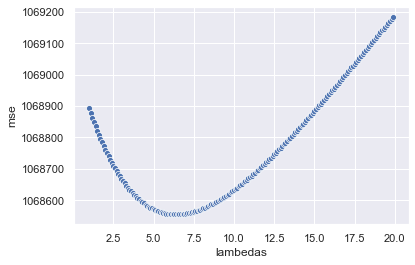

,lambedas,mse
54,6.4,1.068555e+06


RMSE: 1068554.9002242596
Lambeda: 6.400000000000005


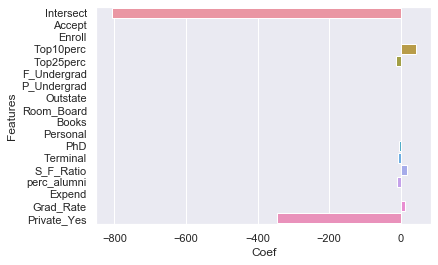

,Features,Coef
0,Intersect,-808.261769
1,Accept,1.240118
2,Enroll,0.293775
3,Top10perc,42.238162
4,Top25perc,-14.374250
5,F_Undergrad,-0.012896
6,P_Undergrad,0.057522
7,Outstate,-0.055904
8,Room_Board,0.135773
9,Books,-0.191998


In [860]:
ridge_best_model = optimize(X_train, y_train, 10, np.arange(1, 20, .1))

**TEST ERROR**

In [862]:
print("Test Error: {}".format(np.sqrt(mse(ridge_best_model.predict(X_test),y_test))))

Test Error: 1230.2863913806934


**Comment:** With an RSME on the test set of 1230.29, ridge regression performs marginally worse than a naive linear regression with all feature (RMSE: 1229.13).

**(d) Fit a lasso model on the training set, with λ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates**

In [870]:
def lasso_cv(X,y,k,alpha):
    
    X_folds = np.array_split(X,k)
    y_folds = np.array_split(y,k)
    
    results = []
    for p in np.arange(k):
        X_test = X_folds[p]
        y_test = y_folds[p]
        X_train = X.drop(X_test.index)
        y_train = y.drop(y_test.index)
        
        # fit
        lasso_regr = linear_model.Lasso(alpha = alpha,fit_intercept=True,normalize=True,max_iter=100000).fit(X_train,y_train)
        y_hat = lasso_regr.predict(X_test)
        
        results += [mse(y_hat,y_test)]
        
    return np.mean(results)
        
def optimize_lasso(X,y,k,lambdas):
    
    results = []
    for i in lambdas:
        lasso_result = lasso_cv(X,y,k,i)
        results+= [[i,lasso_result]]  
    
    plot_results = pd.DataFrame({'lambedas':np.array(results)[:,0],'mse':np.array(results)[:,1]})
    
    sns.scatterplot(x='lambedas',y='mse',data=plot_results)
    plt.show()
    
    display(plot_results[plot_results['mse']==plot_results['mse'].min()].astype(np.float))
    print("RMSE: {}\nLambeda: {}".format(np.sqrt(plot_results.iloc[19][1]),plot_results.iloc[19][0]))
    optimal_lamb = plot_results.iloc[54][0]
    
    best_lasso_model = linear_model.Lasso(alpha= optimal_lamb,fit_intercept=True,normalize=True,max_iter=100000).fit(X,y)
    
    intersect_df = pd.DataFrame({'Features':'Intersect','Coef': [best_lasso_model.intercept_]})
    coef_df = intersect_df.append(pd.DataFrame({'Features': X.columns,'Coef': best_lasso_model.coef_}),ignore_index=True)
    
    sns.barplot(x='Coef',y='Features',data = coef_df)
    plt.show()
    
    display(coef_df)
    
    return best_lasso_model

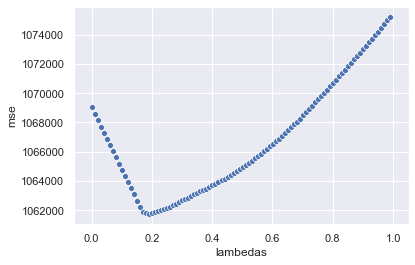

,lambedas,mse
19,0.191,1.061715e+06


RMSE: 1030.3953270677769
Lambeda: 0.19099999999999998


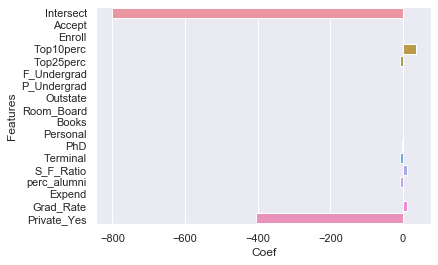

,Features,Coef
0,Intersect,-802.620356
1,Accept,1.228060
2,Enroll,0.243192
3,Top10perc,35.413163
4,Top25perc,-9.173328
5,F_Undergrad,0.000000
6,P_Undergrad,0.046262
7,Outstate,-0.042285
8,Room_Board,0.108738
9,Books,-0.096387


In [871]:
lasso_best_model= optimize_lasso(X_train, y_train, 10, np.arange(.001, 1, .01))

In [876]:
display(HTML('<h3> Test Error </h3>'))
print("Test Error: {}".format(np.sqrt(mse(lasso_best_model.predict(X_test),y_test))))

Test Error: 1231.22568790635


In [880]:
display(HTML('<h3> Results so far... </h3>'))

models = ['OLS','Ridge','Lasso']
resuls = [1229.132621,1230.28639,1231.225687]

pd.DataFrame({'Models':models,'RMSE Test Error': resuls})

,Models,RMSE Test Error
0,OLS,1229.132621
1,Ridge,1230.286390
2,Lasso,1231.225687


**(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.**

In [921]:
def pcr_model(X,y,seed,cv_folds):
    """Perform Principle Component Regression evaluated with
    k-fold cross validation """
    
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    M = X_reduced.shape[1]
    MSEs = []
    for m in np.arange(M):
        model = LinearRegression()
        cv = KFold(n_splits=cv_folds,shuffle=True,random_state=seed)
        cv_score = cross_val_score(model,X_reduced[:,0:m+1],y,cv=cv,scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv_score))]
    
    df=pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)})
    display(pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)}))
    ax = sns.lineplot(x='principal components count', y='RMSE_CV', data=pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)}))
    plt.show();
    
    return df[df['RMSE_CV'] == df['RMSE_CV'].min()]['principal components count'].iloc[0]
    
    

,principal components count,RMSE_CV
0,1,3218.615767
1,2,1632.892149
2,3,1636.123557
3,4,1370.433175
4,5,1377.911455
5,6,1229.472581
6,7,1224.000590
7,8,1172.105110
8,9,1176.675471
9,10,1181.293663


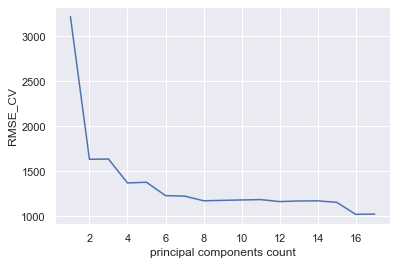

In [936]:
pcr_best = pcr_model(X_train,y_train,1,10)

In [967]:
pca = PCA()
X_reduced = pca.fit_transform(scale(col.drop(['Apps'], axis=1)))

model = LinearRegression().fit(X_reduced[train][:,0:pcr_best+1],y_train)
#Predict
y_hat_pca = model.predict(X_reduced[~train][:,0:pcr_best+1])

best_df= np.sqrt(mse(y_hat_pca, y_test))
display(best_df)

1229.1326212399663

In [968]:
display(HTML('<h3> Results so far... </h3>'))

models = ['OLS','Ridge','Lasso','PCR']
resuls = [1229.132621,1230.28639,1231.225687,1229.1326212399663]

pd.DataFrame({'Models':models,'RMSE Test Error': resuls})

,Models,RMSE Test Error
0,OLS,1229.132621
1,Ridge,1230.286390
2,Lasso,1231.225687
3,PCR,1229.132621


In [1030]:
from sklearn.cross_decomposition import PLSRegression

def pls_cv(X,y,seed,cv_value):
    
    results = []
    for m in range(X.shape[1]):
        cv = KFold(n_splits=cv_value,shuffle=True,random_state=seed)
        cv_score = cross_val_score(PLSRegression(n_components=m+1, scale=True, max_iter=10000),X,y,cv = cv_value,scoring='neg_mean_squared_error')
        results += [np.mean(np.abs(cv_score))]
        
    df = pd.DataFrame({'Principal Component':np.arange(1,X.shape[1]+1),'RMSE': np.sqrt(results)})
    display(df)
    
    sns.lineplot(x='Principal Component',y='RMSE',data=df)
    
    display(df[df['RMSE']==df['RMSE'].min()])
    return df[df['RMSE']==df['RMSE'].min()]['Principal Component'].iloc[0]

,Principal Component,RMSE
0,1,1541.762919
1,2,1379.044230
2,3,1124.798536
3,4,1124.943142
4,5,1084.973473
5,6,1070.079197
6,7,1058.003331
7,8,1039.900352
8,9,1035.951587
9,10,1036.308546


,Principal Component,RMSE
12,13,1033.512372


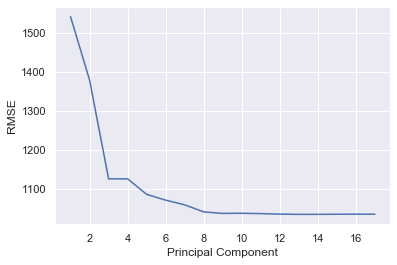

In [1031]:
best_pls = pls_cv(X_train,y_train,1,10)

In [1049]:
Pls_model = PLSRegression(n_components=13,max_iter=10000,scale=True).fit(X_train,y_train)
X_test_r, y_test_r = Pls_model.transform(X_test, y_test)
y_hat_pls  = Pls_model.predict(X_test)

np.sqrt(mse(y_hat_pls.T[0],y_test))

    
#best_df = np.sqrt(mse(y_hat.T[0], y_test))
#display(best_df)

1230.4406511425238

In [1050]:
display(HTML('<h3> Results so far... </h3>'))

models = ['OLS','Ridge','Lasso','PCR','PLS']
resuls = [1229.132621,1230.28639,1231.225687,1229.1326212399663,1230.440651]

pd.DataFrame({'Models':models,'RMSE Test Error': resuls})

,Models,RMSE Test Error
0,OLS,1229.132621
1,Ridge,1230.286390
2,Lasso,1231.225687
3,PCR,1229.132621
4,PLS,1230.440651


**Backward stepwise**

In [1051]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')

selector = selector.fit(X_train, y_train)

y_hat = selector.predict(X_test)
print('RMSE: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE: 1228.0980023182658


**(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?**

In [1094]:
def lm_stats(X,y,y_pred):
    
    try:
        y.shape[1]==1
        y=y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    #residuals
    residuals = np.array(y-y_pred)
    
    # Hat matrix
    H = np.array(np.array(X @ np.linalg.inv(X.T @ X)) @ X.T)
    print()
    # Leverage
    h_ii = H.diagonal()
    
    #external variance
    o_ii = []
    for i in range(X.shape[0]):
        external_res = np.delete(residuals,i)
        o_ii += [np.sqrt( (1 / (X.shape[0]-X.shape[1]-1))  * np.sum(np.square(external_res)))]
    oext = np.array(o_ii)
    
    # external t-studentized
    t_studentized = residuals / (oext * np.sqrt(1-h_ii))
    
    return pd.DataFrame({'residual':residuals,'leverage':h_ii,'t':t_studentized,'y_pred':y_pred})

def lm_plot(lm_stats_df):
    # Parse stats
    t      = lm_stats_df['t']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    
    # figure
    plt.figure(1, figsize=(16, 18))
    ## Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    #Normal Q-Q plot -> indicates which distribution match our dataset, 
    #shows were the dots showing where the quantiles from our data set intersect from the quantiles of the normal distribution 
    # if the dots are on the line, it means that both our data and the distribution have comparable quantiles
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.title('Normal Q-Q', fontweight='bold')
    plt.ylabel('Studentised residuals')

    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    #Residuals vs Leverage
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii,y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

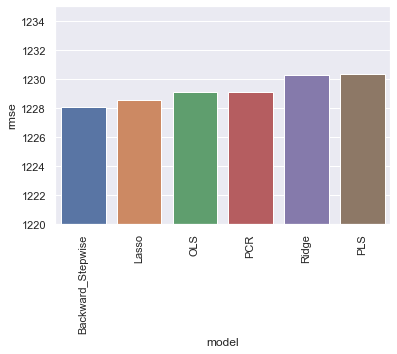

,model,rmse
0,Backward_Stepwise,1228.10
1,Lasso,1228.58
2,OLS,1229.13
3,PCR,1229.13
4,Ridge,1230.29
5,PLS,1230.36


In [1095]:
models = ['Backward_Stepwise', 'Lasso', 'OLS', 'PCR', 'Ridge', 'PLS']
rmses  = [1228.10, 1228.58, 1229.13, 1229.13, 1230.29, 1230.36]
results = pd.DataFrame({'model': models, 'rmse': rmses})

ax = sns.barplot(x='model', y='rmse', data=results)
ax.set_ylim([1220,1235])
plt.xticks(rotation=90)
plt.show();

display(results)

**Comment:**

The mean number of applications received across all colleges is 3002. Our best models predictions yield a means error of +/- 1228 applications. So for the average college we would expect our prediction to be in error by +/- 1228/3002 = 40.9%.

All models return RMSE scores in the range 1228.10 (backward stepwise) - 1230.36 (Partial Least SQuares). Thats a disparity of ...**

In [1096]:
((1230.36 - 1228.10) / 1230.36) *100

0.18368607562014297

... 0.18%, so there really isn't much between them in this setting.

Let's take a look at the diagnostics for the best model found by backward stepwise selection...

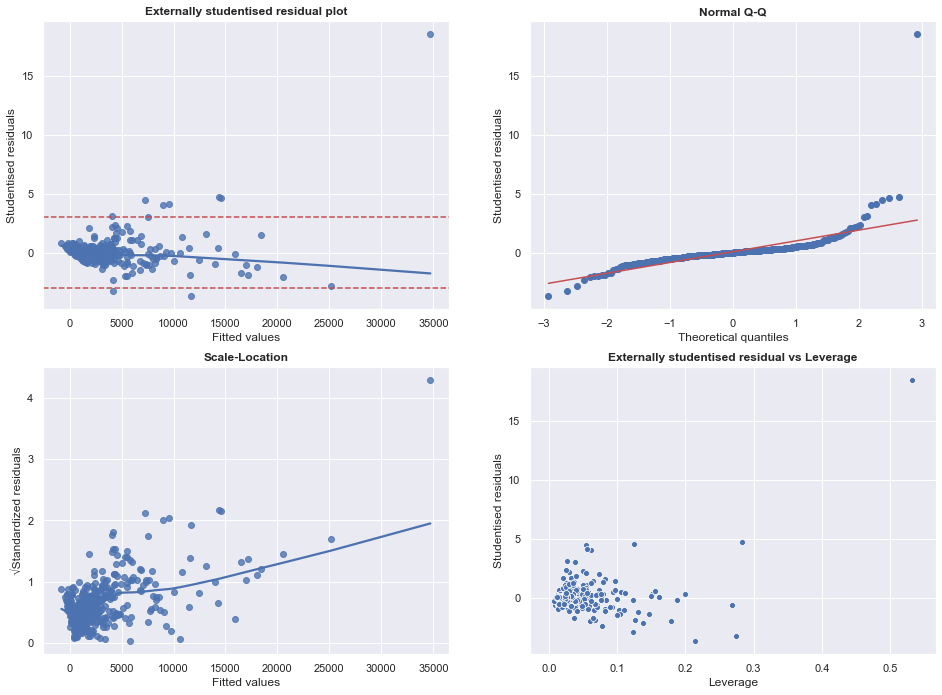

In [1097]:
lm_plot(lm_stats(X_test, y_test, y_hat))

We immediately see a very high leverage outlier. There's some none normal distributions, some heteroscedaticity and some no non-linear relationships.